In [45]:
#Statistical Analyses of Venture Capital Data

This notebook will be used for the analysis of venture capital data. It exports venture capital data from crunchbase and compares them to internet search trend and news trend data downloaded from google trends will various statistical analyses on this dataset

##Preparations

First, we need to input the start date and the end date for the export of google trends and google news data. Additionally, we need the industries we want to analyze, which will be saved as a list that we will itereate through.
The earliest start date is due to the late emerge the Jan 1st 2008 and thus will be the default, while the end date will be today. If we want to use a different time frame, it can be specified now.
Further, we specify the frequency on which we aggregate the investment data. This is important for the statistical analyses due to the low average number of daily venture capital deals.
Additionally, we specify the investment type, because volumes for later stage investment are way higher then for early stage investments and, if we want, the country of the start-up companies.

In [46]:
startDate = '2008-01-01' #Dateformat is YYYY-MM-DD
endDate = '2015-06-30' ##Dateformat is YYYY-MM-DD
industries = ['Big Data','Cloud Computing', 'Predictive Analytics']
frequency = 'quarterly' #choose from [yearly, monthly, quarterly]
investment_type = 'venture' #choose from
country = 'USA'

Further, we need access keys for the google exporter and the crunchbase exporter. For the google export, we don't need google developer tools, but cans simply use a google account with the e-mail and password. For the crunchbase exporter, we need to apply for a key, which can  be done here:
http://data.crunchbase.com/v3/page/accessing-the-dataset
I saved my password combinations in a text file, but they can be just typed in directly. Directly typed strings are prioritized.

In [47]:
pwDict = {}

google_account = None
google_pw = None
crunchbase_access = None

path_to_keys_file = './keys.txt'
if google_account == None or google_pw == None or crunchbase_access == None:
    with open(path_to_keys_file, 'r') as keyFile:
        lines = keyFile.readlines()
        for line in lines:
            key,value = line.split('=')
            pwDict[key] = value.rstrip()

if google_account == None:
    google_account = pwDict['googleUserName']
if google_pw == None:
    google_pw = pwDict['googlePassword']
if crunchbase_access == None:
    crunchbase_access = pwDict['crunchBaseKey']

##Data Retrieval

Next, we grab the crunchbase data. We use the excel file, because the API does not grant an overviewing access to the venture capital data. For less download traffic, we save the file to the excel folder and check first if it is already there. But first we import all necessary libraries.

In [48]:
import sys
import os
import requests
import datetime
import time
from random import randint
from urllib import urlencode

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [49]:
#Transform start date and end date to date format
startDateFormat = datetime.datetime.strptime(startDate, '%Y-%m-%d')
endDateFormat = datetime.datetime.strptime(endDate, '%Y-%m-%d')

cbUrl = 'https://api.crunchbase.com/v/3/excel_export/crunchbase_export.xlsx?user_key=%s' % crunchbase_access
if not os.path.exists('./Excel'):
    os.mkdir('./Excel')
if not os.path.exists('./Excel/excelExport.xlsx'):
    resp = requests.get(cbUrl)
    with open('./Excel/excelExport.xlsx', 'wb') as output:
        output.write(resp.content)

#Load Excel file and import as a pandas data frame
cbExcelFile = pd.ExcelFile('./Excel/excelExport.xlsx')
df_cb = cbExcelFile.parse('Rounds', index_col = None, na_values=['NA'])

#Transform fundet_at column to datetime format
df_cb['funded_at'] = pd.to_datetime(df_cb['funded_at'])

#Filter out relevant results - between starting and enddate, matching industry. Return sorted dataframe
df_cb = df_cb[(df_cb['funded_at'] >= startDate) & (df_cb['funded_at'] <= endDate)].sort(columns = 'funded_at')

In the next step, we get the Google Trends and News data for the industries we want to analyze. For every industry, we create a time series dataframe. We use the pytrends package to download the google trend reports and modify it slightly, which we will do in this first step

In [50]:
from pytrends.pyGTrends import pyGTrends
class googleExport(pyGTrends):
    '''Change the pyGTrends class to consider additional arguments in the request report'''
    def request_report(self, keywords, gprop = None, hl='en-US', cat=None, geo='US',
                        date=None, use_topic=False):
        # use_topic prevents re-urlencoding of topic id's.
        if use_topic:
            query_param = 'q=' + keywords
        else:
            query_param = str(urlencode({'q':keywords}))

        # This logic handles the default of skipping parameters
        # Parameters that are set to '' will not filter the data requested.
        if cat is not None:
            cat_param = '&cat=' + cat
        else:
            cat_param = ''
        if date is not None:
            date_param = '&' + str(urlencode({'date':date}))
        else:
            date_param = ''
        if geo is not None:
            geo_param = '&geo=' + geo
        else:
            geo_param = ''
        hl_param = '&hl=' + hl
        if gprop == 'news':
            gprop_param  = '&gprop=' + gprop
        else:
            gprop_param = ''

        # These are the default parameters and shouldn't be changed.
        cmpt_param = "&cmpt=q"
        content_param = "&content=1"
        export_param = "&export=1"

        combined_params = query_param + cat_param + date_param \
                          + geo_param + gprop_param + hl_param + cmpt_param + content_param + export_param

        raw_data = self.opener.open("http://www.google.com/trends/trendsReport?" + combined_params).read()
        self.decode_data = raw_data.decode('utf-8')

        if self.decode_data in ["You must be signed in to export data from Google Trends"]:
            print("You must be signed in to export data from Google Trends")
            raise Exception(self.decode_data)

This google export file can be used both for the news trends and the google search trends. Thus, we use the exporter for both time series and define a framer class to save some work.

In [51]:
def googleFramer(google_username, google_pw, industry, exporter):
    '''Calls the google export class and creates a pandas dataframe'''
    
    #Need to be none for search export to grab the google trend report
        
    # Create the csv downloader object
    downloader = googleExport(google_username, google_pw)

    # Wait some time to avoid blocking by google
    time.sleep(randint(0, 5))

    # Attributes for the url - differentiate between trends and news
    downloader.request_report(keywords = industry, gprop = exporter, geo = 'US', hl = 'en-US')
    csvTable = downloader.get_data()
    
    # Export only relevant week data and save in a dictionary
    weeksTable = csvTable.split('\n')[5:]
    weekDict = {}
    for i in weeksTable:
        if i == '':
            break
        else:
            interval,value = i.split(',')
            try:
                week1,week2 = interval.split(' - ')
            except:
                week2 = interval
            weekDict[week2] = value
    
    #Transform csv data and save on a daily basis
    rng = pd.date_range(startDateFormat,endDateFormat, freq = 'D')
    week = Series(weekDict, name = 'Google_Index_%s'%exporter.capitalize())
    week.index = pd.to_datetime(week.index)
    df_google = pd.concat([pd.DataFrame(index=rng),week],axis=1).fillna(method = 'backfill')
    return df_google.ix[startDate:endDate]

After defining the export function, we iterate through the industries and append the dataframes in a dictionary.

In [60]:
df_google_dict = {}
for industry in industries:
    df_google_dict_interim = {}
    for export_type in ['news','trends']:
        df_google_dict_interim[export_type] = googleFramer(google_account,google_pw,industry,exporter = export_type)
    df_google_dict[industry] = df_google_dict_interim

Awesome. Now we have everything we need. We just have to have to concat the dataframes and create a joined dataframe for each industry. To do that, we define a summarizing function. 

In [61]:
def dataSummarizer(industry,frequency,df_cb,
                   google_df,invest_type,country = None):
    '''Takes the dataframes from the exporter, concats them and returns a dataframe based on the wished frequency'''
    
    #First, create an empty dataframe with the dates between start and enddate as index for a daily basis
    dateRange = pd.date_range(start = startDate, 
                           end = endDate,
                           freq = 'D')
    dailyTable = DataFrame(index = dateRange)

    # Reduce funding rounds to funding rounds in given industry with a map function
    def matchIndustry(x):
        industryList = str(x).lower().split('|')
        if industry.lower() in industryList:
            return True
        else:
            return False
    df_cb['IndustryPresent'] = df_cb[['company_category_list']].applymap(matchIndustry)
    df_cb = df_cb[df_cb['IndustryPresent'] == True]
    
    #Reduce to deals from specified country
    if not country:
        df_cb = [df_cb['company_country_code'] == country]
        
    # Match crunchbasedata to date dataframe, summarizing daily investments, in this first version I only consider venture capital investments, later a differitation will be possible  
    crunchBaseSub = df_cb[(df_cb['funding_round_type'] == invest_type)]
    crunchBaseArt = crunchBaseSub.groupby(['funded_at'])
    
    # Concate the tables from crunchbase, from Google News and Google Trends
    dailyTable = pd.concat([dailyTable,crunchBaseArt.count()['IndustryPresent'], 
                            crunchBaseArt.sum()['raised_amount_usd'], google_df['news'],
                            google_df['trends']], axis = 1, join = 'outer')
  
    dailyTable.rename(columns = {'IndustryPresent': 'Funding_Rounds_Number','raised_amount_usd' : 'Funding_Volume'}, inplace = True)
    dailyTable['Google_Index_News'] = dailyTable['Google_Index_News'].astype(int)
    dailyTable['Google_Index_Trends'] = dailyTable['Google_Index_Trends'].astype(int)
    
    calc_dict = {'Funding_Rounds_Number' : 'sum', 'Funding_Volume' : ['sum','mean'], 'Google_Index_News' : 'mean', 'Google_Index_Trends' : 'mean'}
    if frequency.lower() in ['y','year','yearly']:
        return dailyTable.groupby([lambda x: x.year]).agg(calc_dict)
    elif frequency.lower() in ['q','quarter','quarterly']:
        return dailyTable.groupby([lambda x: x.year, lambda x: x.quarter]).agg(calc_dict)
    elif frequency.lower() in ['m','month','monthly']:
        return dailyTable.groupby([lambda x: x.year, lambda x: x.quarter, lambda x: x.month]).agg(calc_dict)
    else:
        return None

In [62]:
df_dict_final = {}
for industry in industries:
    df_dict_final[industry] = dataSummarizer(industry,frequency,df_cb,
                              df_google_dict[industry],investment_type,'USA')

With this dataframe dictionary we can now start to make statistical analyses, like the calculation of correlations, linear regression etc.

## Statistical Analyses

Now we can start the interesting part and analyze our dataset. We start with describing the data.

In [95]:
my_df = df_dict_final[industries[1]]
my_df.name = industries[1]

In [96]:
my_df.sort(axis=1,inplace =True)
my_df.describe()

Funding_Rounds_Number   Funding_Volume               Google_Index_News  \
                        sum             mean           sum              mean   
count             30.000000        30.000000  3.000000e+01         30.000000   
mean              27.133333  14431454.302821  3.054418e+08         17.090193   
std                8.708828   7382460.845548  2.218662e+08          9.434260   
min               12.000000   5206749.928571  6.965140e+07          0.000000   
25%               19.000000   8912924.965278  1.219750e+08         11.266304   
50%               29.000000  13156409.015873  2.511552e+08         15.116239   
75%               33.000000  18038110.534091  4.071904e+08         22.481605   
max               41.000000  35554150.481481  9.599621e+08         35.456522   

      Google_Index_Trends  
                     mean  
count           30.000000  
mean            43.343986  
std             22.011192  
min              8.384615  
25%             25.390640  
50%             36.673913  
75%             62.964674  
max             82.688889

Then, we check correlations between the columns in our dataset.

In [97]:
my_df.corr()

Funding_Rounds_Number Funding_Volume            \
                                             sum           mean       sum   
Funding_Rounds_Number sum               1.000000       0.497153  0.684658   
Funding_Volume        mean              0.497153       1.000000  0.947375   
                      sum               0.684658       0.947375  1.000000   
Google_Index_News     mean              0.121453      -0.211367 -0.124590   
Google_Index_Trends   mean             -0.153021      -0.514976 -0.427183   

                           Google_Index_News Google_Index_Trends  
                                        mean                mean  
Funding_Rounds_Number sum           0.121453           -0.153021  
Funding_Volume        mean         -0.211367           -0.514976  
                      sum          -0.124590           -0.427183  
Google_Index_News     mean          1.000000            0.736735  
Google_Index_Trends   mean          0.736735            1.000000

Next, we plot the data to visualize the information. We normalize the scales of the different axis by dividing the cells by the sum of the columns.

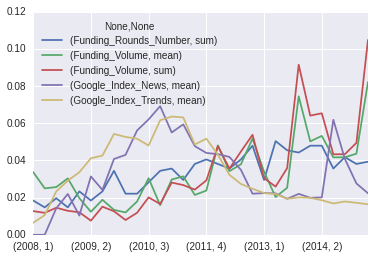

In [98]:
df_sums = my_df.sum(axis = 0)
normalized_df = my_df.div(df_sums,axis = 1)
normalized_df.plot()
plt.show()

Looks like the number of funding rounds show some interesting correlations. We use seaplot plot functions to take a closer look at that

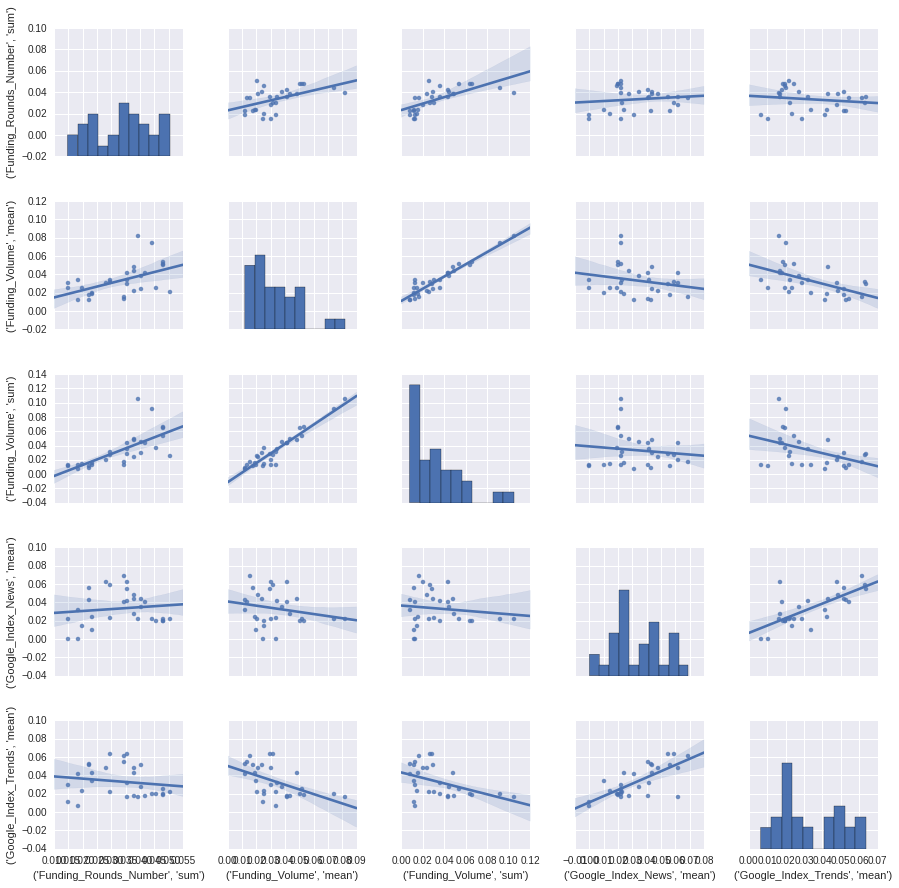

In [99]:
sns.pairplot(normalized_df,kind='reg',diag_kind='hist')